# Load Data

Load sales data from S3 / HDFS. We use the built-in "csv" method, which can use the first line has column names and which also supports infering the schema automatically. We use both and save some code for specifying the schema explictly.

We also peek inside the data by retrieving the first five records.

In [1]:
from pyspark.sql.functions import *

raw_data = spark.read\
    .option("header","true")\
    .option("inferSchema","false")\
    .csv("s3://dimajix-training/data/kc-house-data")

raw_data.limit(5).toPandas()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.721,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Inspect Schema

Now that we have loaded the data and that the schema was inferred automatically, let's inspect it.

In [3]:
raw_data.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: string (nullable = true)
 |-- bedrooms: string (nullable = true)
 |-- bathrooms: string (nullable = true)
 |-- sqft_living: string (nullable = true)
 |-- sqft_lot: string (nullable = true)
 |-- floors: string (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_above: string (nullable = true)
 |-- sqft_basement: string (nullable = true)
 |-- yr_built: string (nullable = true)
 |-- yr_renovated: string (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- sqft_living15: string (nullable = true)
 |-- sqft_lot15: string (nullable = true)



In [4]:
from pyspark.sql.types import *

data = raw_data.withColumn("price", raw_data.price.cast(FloatType())) \
    .withColumn("bedrooms", raw_data.bedrooms.cast(FloatType())) \
    .withColumn("bathrooms", raw_data.bathrooms.cast(FloatType())) \
    .withColumn("sqft_living", raw_data.sqft_living.cast(FloatType())) \
    .withColumn("sqft_lot", raw_data.sqft_lot.cast(FloatType())) \
    .withColumn("floors", raw_data.floors.cast(FloatType())) \
    .withColumn("sqft_above", raw_data.sqft_above.cast(FloatType())) \
    .withColumn("sqft_basement", raw_data.sqft_basement.cast(FloatType())) \
    .withColumn("yr_built", raw_data.yr_built.cast(IntegerType())) \
    .withColumn("yr_renovated", raw_data.yr_renovated.cast(IntegerType())) \
    .withColumn("sqft_living15", raw_data.sqft_living15.cast(FloatType())) \
    .withColumn("sqft_lot15", raw_data.sqft_lot15.cast(FloatType()))

data.printSchema()

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- price: float (nullable = true)
 |-- bedrooms: float (nullable = true)
 |-- bathrooms: float (nullable = true)
 |-- sqft_living: float (nullable = true)
 |-- sqft_lot: float (nullable = true)
 |-- floors: float (nullable = true)
 |-- waterfront: string (nullable = true)
 |-- view: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sqft_above: float (nullable = true)
 |-- sqft_basement: float (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- zipcode: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- sqft_living15: float (nullable = true)
 |-- sqft_lot15: float (nullable = true)



# Initial Investigations

As a first step to get an idea of our data, we create some simple visualizations. We use the Python matplot lib package for creating simple two-dimensional plots, where the x axis will be one of the provided attributes and the y axis will be the house price.

In [5]:
%matplotlib inline

In [6]:
# Import relevant Python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## House Price in Relation to sqft_living

Probably one of the most important attributes is the size of the house. This is provided in the data in the column "sqft_living". We extract the price column and the sqft_living column and create a simple scatter plot.

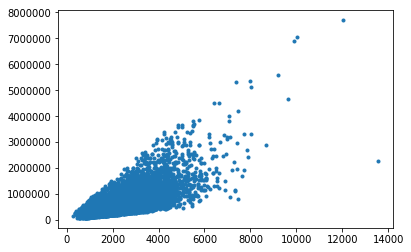

In [7]:
# Extract price and one of the attributes
price = data.select("price").toPandas()
sqft_living = data.select("sqft_living").toPandas()

# Create simple scatter plot
plt.plot(sqft_living, price, ".")

## House Price in Relation to sqft_lot

Another interesting attribute for predicting the house price might be the size of the whole lot, which is provided in the column "sqft_lot". So let's create another plot, now with "price" and "sqft_lot".

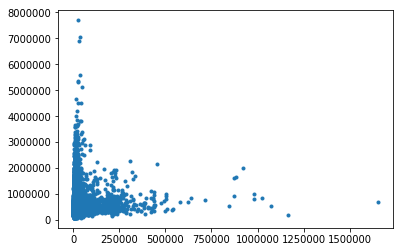

In [8]:
price = data.select("price").toPandas()
sqft_lot = data.select("sqft_lot").toPandas()

plt.plot(sqft_lot, price, ".")

# Perform Linear Regression

Let's try to fit a line into the picture by performing a linear regression. This is done in two steps:
1. Extract so called features from the raw data. The features have to be stored in a new column of type "Vector"
2. Train a linear regression model

In [9]:
from pyspark.ml.feature import *
from pyspark.ml.regression import *

# Extract features using VectorAssembler
vector_assembler = VectorAssembler(inputCols=['sqft_living'], outputCol='features')
features = vector_assembler.transform(data)

# Traing linear regression model
regression = LinearRegression(featuresCol='features',labelCol='price')
model = regression.fit(features)

## Inspect Model

Let's inspect the generated linear model. It has two fields, "intercept" and "coefficients" which completely describe the model.

The basic formular of the model is

    y = SUM(coeff[i]*x[i]) + intercept
    
where y is the prediction variable, and x[i] are the input feature.

In [10]:
print("Intercept: " + str(model.intercept))
print("Coefficients: " + str(model.coefficients))

Intercept: -43580.743094473895
Coefficients: [280.62356789744814]


## Plot Data and Model

Now let's overlay the original scatter plot with the trained model. The model encodes a line, which can be overlayed by an additional invocation of "plt.plot".

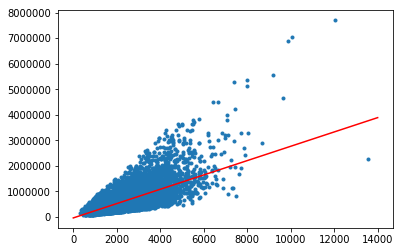

In [11]:
# For plotting the model, we need to generate input and output values. Input values are stored in "model_x"
model_x = np.linspace(0,14000,100)
# model_y contains the model applied to model_x. The model has only one feature and an intercept
model_y = model_x * model.coefficients[0] + model.intercept

plt.plot(sqft_living, price, ".")
plt.plot(model_x, model_y, "r")

# Measuring Fit

Now the important question of course is, how well does the model approximate the real data. We can find our by transforming our input data using the model. This is done by using the function

    model.transform
    
which accepts one parameter and adds a new column "prediction" to input data, which contains the evaluated model for each record.

In [12]:
prediction = model.transform(features)
prediction.limit(5).toPandas()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,features,prediction
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,0.0,1955,0,98178,47.5112,-122.257,1340.0,5650.0,[1180.0],287555.067025
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,400.0,1951,1991,98125,47.721,-122.319,1690.0,7639.0,[2570.0],677621.826402
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,0.0,1933,0,98028,47.7379,-122.233,2720.0,8062.0,[770.0],172499.404187
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,910.0,1965,0,98136,47.5208,-122.393,1360.0,5000.0,[1960.0],506441.449985
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,0.0,1987,0,98074,47.6168,-122.045,1800.0,7503.0,[1680.0],427866.850973


## Manually Calculate RMSE

Using SQL we compute the root mean squared error (RMSE). Formally it is calculated as

    SQRT(SUM((price - prediction)**2) / n)
    
where n is the number of records.

In [13]:
prediction.selectExpr("sqrt(sum((price - prediction)*(price-prediction)) / count(*)) as RMSE").toPandas()

,RMSE
0,261440.790301


## Use Built in Functionality to Measure the Fit
Of course Spark ML already contains evaluators for the most relevant metrics

In [14]:
from pyspark.ml.evaluation import *

evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
evaluator.evaluate(prediction)

261440.79030067223

# Measuring Generalization of Model

Now we have an idea how well the model approximates the given data. But for machine learning it is more important to understand how well a model generalizes from the training data to new data. New data could contain different outliers.

In order to measure the generalization of the model, we need to change our high level approach. Our new approach needs to provide distinct sets of training data and test data. We can create such data using the Spark method "randomSplit".

In [15]:
train_data, test_data = features.randomSplit([0.8,0.2], seed=0)

# Train a linear regression model
regression = LinearRegression(featuresCol='features',labelCol='price')
model = regression.fit(train_data)

# Now create predictions, but this time for the "test_data" and NOT for the training data itself
prediction = model.transform(test_data)

# Evaluate model using RegressionEvaluator again, but this time using the "prediction" data frame
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
evaluator.evaluate(prediction)

261165.38928524387

# Improving Prediction

Now that we have a metric and a valid approachm, the next question is: How can we improve the model? So far we only used the column "sqft_living" for building the model, but we have much more information about the houses. A very simple way is to include more attributes into the feature vector.

Remember that the schema looked as follows:

    root
     |-- id: long (nullable = true)
     |-- date: string (nullable = true)
     |-- price: decimal(7,0) (nullable = true)
     |-- bedrooms: integer (nullable = true)
     |-- bathrooms: double (nullable = true)
     |-- sqft_living: integer (nullable = true)
     |-- sqft_lot: integer (nullable = true)
     |-- floors: double (nullable = true)
     |-- waterfront: integer (nullable = true)
     |-- view: integer (nullable = true)
     |-- condition: integer (nullable = true)
     |-- grade: integer (nullable = true)
     |-- sqft_above: integer (nullable = true)
     |-- sqft_basement: integer (nullable = true)
     |-- yr_built: integer (nullable = true)
     |-- yr_renovated: integer (nullable = true)
     |-- zipcode: integer (nullable = true)
     |-- lat: double (nullable = true)
     |-- long: double (nullable = true)
     |-- sqft_living15: integer (nullable = true)
     |-- sqft_lot15: integer (nullable = true)
     
We simply use all real numeric columns. Some columns like "condition", "grade", "zipcode" are categorical variables, which we don't want to use now.

In [16]:
# Extract features using VectorAssembler
vector_assembler = VectorAssembler(inputCols=[
            'bedrooms',
            'bathrooms',
            'sqft_living',
            'sqft_lot',
            'floors',
            'sqft_above',
            'sqft_basement',
            'yr_built',
            'yr_renovated',
            'sqft_living15',
            'sqft_lot15'], 
        outputCol='features')
features = vector_assembler.transform(data)

# Again split into training and test data
train_data, test_data = features.randomSplit([0.8,0.2], seed=0)

# Traing linear regression model
regression = LinearRegression(featuresCol='features',labelCol='price')
model = regression.fit(train_data)
prediction = model.transform(test_data)

# Evaluate model
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
evaluator.evaluate(prediction)

237093.75764364522